# Fashion Image Search Engine

***
In this notebook, we will perform Fashion Image Search (also called, Content Based Recommender Engine or CBR) using Tensorflow.

We will use ResNet50 model for finding image similarity:

**ResNet 50**

***
* ResNet stands for Residual Network.
* The ResNet 50 is a 50 layer deep network.
* It had a special unit or a special connection called the skip connections, which allowed to train these deep layered models effeciently.
* In the skip connection, the inputs are directly connected to the output layer. Then the network is forced to model h(x) - x, where h(x) hypothesis function and x is the input. This is called residual learning as we are modelling the residuals (errors).
* ResNet is also available in 34 layers as well as 152 layers deep networks.
***

***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
from random import sample
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.models import Model
from pathlib import Path
Image.LOAD_TRUNCATED_IMAGES = True
import requests
from io import BytesIO
import os

In [3]:
os.chdir('D:\Projects\Flipkart')

In [9]:
def Gather_Images():
    categories = ['hat', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']

    images = []

    for i in categories:
        # Specify the path to the images folder
        path = 'dataset/Images/' + i

        # Get a list of all file names in the images folder
        file_names = os.listdir(path)

        for name in file_names:
            name = 'dataset/Images/' + i + '/' + name
            images.append(name)

    return images

In [10]:
images = Gather_Images()
images[0]

'dataset/Images/hat/6.jpg'

In [11]:
# Create a pandas DataFrame with the 'Image_Path' column
data = {'Image_Path': images}
df = pd.DataFrame(data)

df

,Image_Path
0,dataset/Images/hat/6.jpg
1,dataset/Images/hat/11.jpg
2,dataset/Images/hat/7.jpg
3,dataset/Images/hat/3.jpg
4,dataset/Images/hat/8.jpg
...,...
3488,dataset/Images/t-shirt/619.jpg
3489,dataset/Images/t-shirt/933.jpg
3490,dataset/Images/t-shirt/702.jpg
3491,dataset/Images/t-shirt/1024.jpg


In [12]:
df.shape[0]

3493

In [13]:
df.iloc[36]['Image_Path']

'dataset/Images/hat/72.jpg'

# Image Search Engine using Keras and Tensorflow

In [14]:
# Creating a class for feature extraction and finding the most similar images

class FeatureExtractor:

    # Constructor
    def __init__(self, arch='ResNet50'):

        self.arch = arch


        # Using the ResNet 50 as the architecture with ImageNet weights
        base_model = ResNet50(weights = 'imagenet')
        self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)


    # Method to extract image features
    def extract_features(self, img):

        # The ResNet 50 model has images of 224,244 as input
        img = img.resize((224, 224))

        # Convert the image channels from to RGB
        img = img.convert('RGB')

        # Convert into array
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Proprocess the input as per ResNet 50
        x = resnet_preprocess(x)


        # Extract the features
        features = self.model.predict(x)

        # Scale the features
        features = features / np.linalg.norm(features)

        return features


## Testing the Feature Extractor

In [ ]:
# Extract the features for a sample of 10000 random images
index_values = np.random.randint(low = 0, high = df.shape[0]-1, size = min(10000, df.shape[0]))     # shape[0] = number of rows
model_images = df.iloc[index_values]['Image_Path']

In [16]:
# Create the model object and extract the features images from /dataset (ResNet)
resnet_feature_extractor = FeatureExtractor(arch='ResNet')

# dictionary to store the features and index of the image
image_features_resnet = {}
for i, (idx, img_path) in enumerate(zip(index_values, model_images)):

    # Extract features and store in a dictionary
    img = image.load_img(img_path)
    feature = resnet_feature_extractor.extract_features(img)
    image_features_resnet[idx] = feature

1/1 [==============================] - 0s 41ms/step


In [45]:
# Create a query
queryImage_idx = np.random.randint(low = 0, high = df.shape[0] - 1)
queryImage = image.load_img('Realtime data collection/Trending fashion/7.jpg')

# Extract Features from queryImage
queryFeatures_Resnet = resnet_feature_extractor.extract_features(queryImage)

1/1 [==============================] - 0s 29ms/step


In [46]:
# Compute Similarity between queryFeatures and every other image in image_features_vgg, image_features_resnet, image_features_xception
similarity_images_resnet = {}
for idx, feat in image_features_resnet.items():

    # Compute the similarity using Euclidean Distance
    similarity_images_resnet[idx] = np.sum((queryFeatures_Resnet - feat)**2) ** 0.5

similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]

========================================== QUERY IMAGE ===============================================


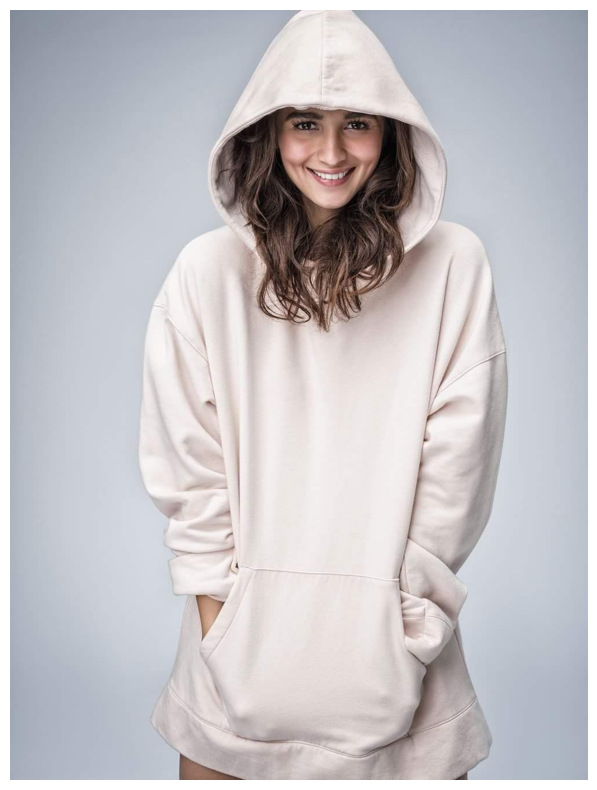


========================================== ResNet Results =============================================


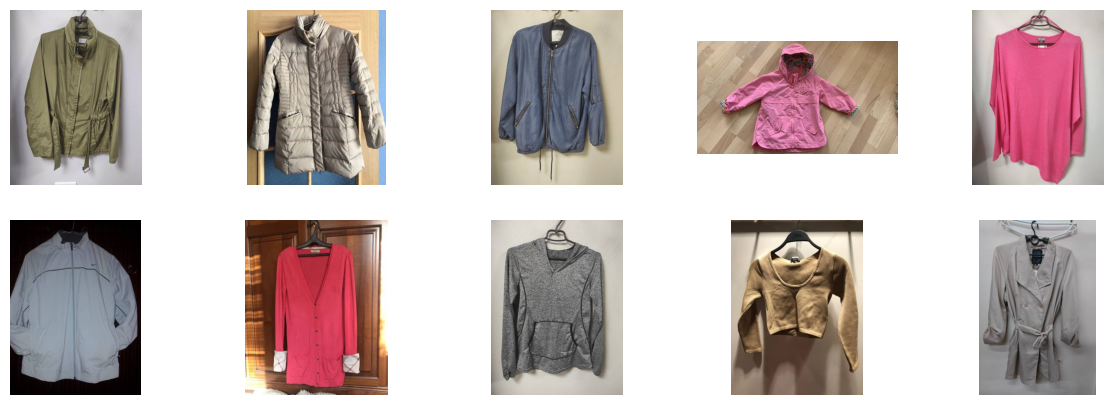

In [47]:
# Plot the results from all three models and prepare a comparison

print("========================================== QUERY IMAGE ===============================================")
plt.figure(figsize=(10,10))
plt.imshow(image.img_to_array(queryImage, dtype='int'))
plt.axis('off')
plt.show()
print("======================================================================================================")
print()


top_10_similar_imgs_Resnet = df.iloc[top_10_indexes_resnet]['Image_Path']
brand_Resnet = df.iloc[top_10_indexes_resnet]['Image_Path']


print("========================================== ResNet Results =============================================")
fig = plt.figure(figsize=(15,5))
for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_Resnet, brand_Resnet)):
    plt.subplot(2, 5, i+1)
    img = image.load_img(img_path)
    img_arr = image.img_to_array(img, dtype='int')
    plt.imshow(img_arr)
    # plt.xlabel(price)
    # plt.title(brand)
    plt.axis('off')
plt.show()

In [38]:
def testModel(img_url):

    # Testing the architectures on external images

    '''Read the inserted url'''
    img_url = img_url
    response = requests.get(img_url)
    queryImage = Image.open(BytesIO(response.content))

    # Using the Resnet model to generate similar images
    queryFeatures_Resnet = resnet_feature_extractor.extract_features(queryImage)

    similarity_images_resnet = {}

    for idx, feat in image_features_resnet.items():

        # Compute the similarity using Euclidean Distance
        similarity_images_resnet[idx] = np.sum((queryFeatures_Resnet - feat)**2) ** 0.5

    # Extracting the top 10 similar images
    similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
    top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]


    # Plotting the images
    top_10_similar_imgs_RESNET = df.iloc[top_10_indexes_resnet]['Image_Path']
    brand_RESNET = df.iloc[top_10_indexes_resnet]['Image_Path']

    print("===================== QUERY IMAGE ==========================")
    plt.figure(figsize=(8,8))
    queryImage_arr = image.img_to_array(queryImage, dtype='int')
    plt.imshow(queryImage_arr)
    plt.axis('off')
    plt.show()
    print("=============================================================")

    fig = plt.figure(figsize=(15,5))
    print("===================== SIMILAR IMAGES ==========================")
    for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_RESNET, brand_RESNET)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        # plt.xlabel(price)
        # plt.title(brand)
        plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 40ms/step
===================== QUERY IMAGE ==========================


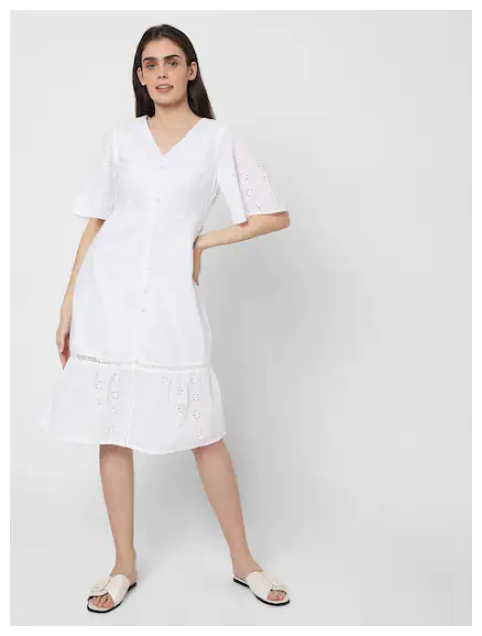

===================== SIMILAR IMAGES ==========================


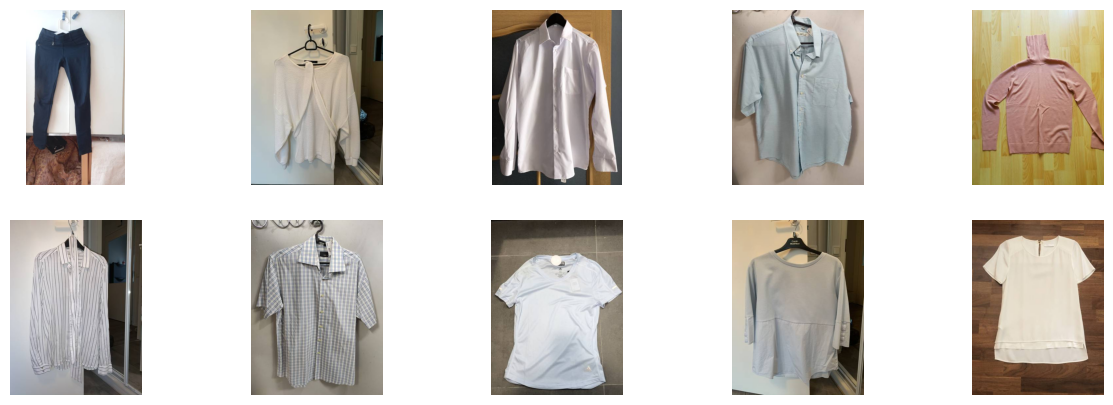

In [31]:
# Call the function
img_url = "https://assets.myntassets.com/f_webp,dpr_2.0,q_60,w_210,c_limit,fl_progressive/assets/images/16517990/2021/12/14/186c22ac-5678-401e-a491-f2f9d58b8aee1639492696377VeroModaWhiteA-LineDress1.jpg"
testModel(img_url)

1/1 [==============================] - 0s 40ms/step
===================== QUERY IMAGE ==========================


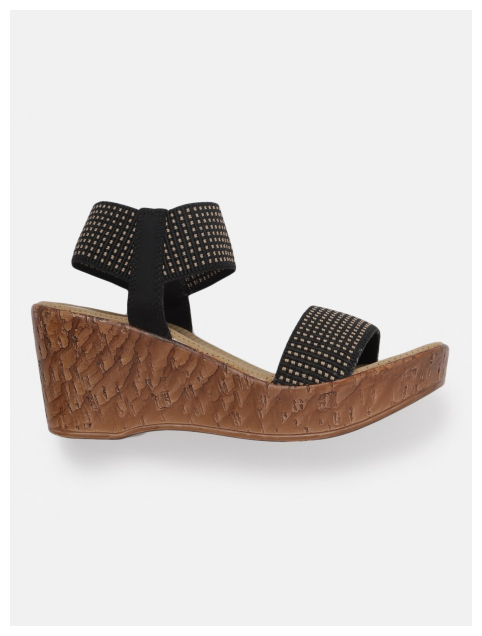

===================== SIMILAR IMAGES ==========================


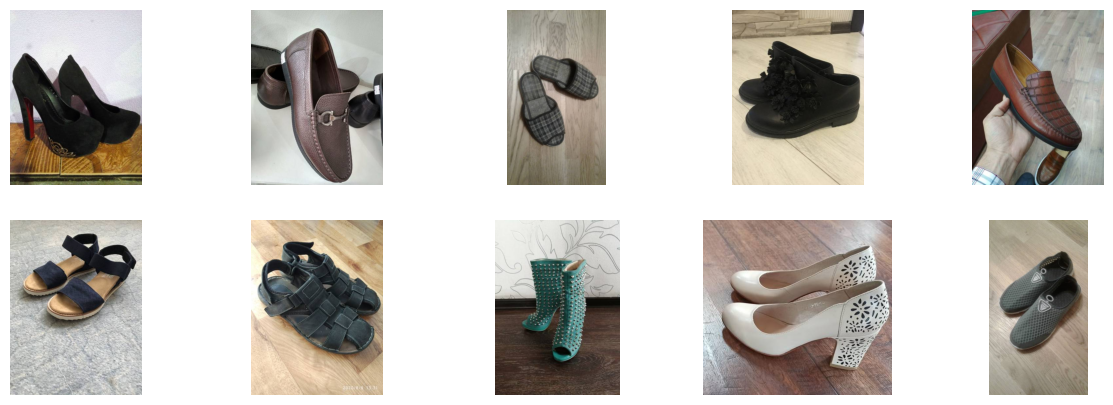

In [32]:
# Call the function
img_url = "https://assets.myntassets.com/h_1440,q_90,w_1080/v1/assets/images/8607853/2021/10/27/3dc9c459-0a09-4a64-8656-c61e762ddb2f1635331357142CatwalkWomenBlackBeigeSolidSandals2.jpg"
testModel(img_url)